In [28]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from collections import Counter
from collections import defaultdict
from nltk.corpus import brown
import gensim
from gensim.models import Word2Vec
import torch
from torch import nn
import torch.nn.functional as F 
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

nltk.download('brown')
nltk.download('universal_tagset')


[nltk_data] Downloading package brown to /home/aditya/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/aditya/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [29]:
tagset = ['NOUN', 'VERB', '.', 'ADP', 'DET', 'ADJ', 'ADV', 'PRON', 'CONJ', 'PRT', 'NUM', 'X']
identity = torch.eye(12, dtype =torch.double)
tagset_dict = {'NOUN':identity[0,:], 'VERB':identity[1,:], '.':identity[2,:], 'ADP':identity[3,:], 'DET':identity[4,:], 'ADJ':identity[5,:], 'ADV':identity[6,:], 'PRON':identity[7,:], 'CONJ':identity[8,:], 'PRT':identity[9,:], 'NUM':identity[10,:], 'X':identity[11,:]}

words = list(brown.tagged_words(tagset='universal'))
print(words[0])
print(len(words))

('The', 'DET')
1161192


In [30]:
def tag_frequency(tag, words):
    total = len(words)
    tagcount = Counter(tag) 
    tagfreq = {}

    for i in tagcount.keys():
        tagfreq[i] = tagcount[i]/total

    return tagcount, tagfreq

def emission_probs(tokens, words, tagcount):
    tokenTags = defaultdict(Counter)

    for token_i, tag_i in words:
        tokenTags[token_i][tag_i] += 1
    
    for tag_i in tagset:
        for token_i in tokens:
            if tokenTags[token_i][tag_i] >= 1:
                tokenTags[token_i][tag_i] = tokenTags[token_i][tag_i]/(tagcount[tag_i])

    return tokenTags

def transition_probs(tag, words, tagcount):
    tokens, tag = zip(*words)
    pl = len(tag) - 1
    tagtags = defaultdict(Counter)

    for i in range(pl-1):
        tagtags[tag[i]][tag[i+1]] += 1

    for tag_i in tagset:
        for tag_j in tagset:
            tagtags[tag_i][tag_j] = tagtags[tag_i][tag_j]/(tagcount[tag_i])

    return tagtags

In [31]:
v_size = 128

def Viterbi_vec(words, test): 

    tokens, tag = zip(*words)
    
    data_w = []
    temp_w = []
    n_w = len(tokens)
    for i in range(n_w):
        temp_w.append(tokens[i])
        if tokens[i] == ".":
            data_w.append(temp_w)
            temp_w = []
    data_w.append(temp_w)
    model_train = gensim.models.Word2Vec(data_w, min_count = 1, vector_size = v_size, window = 5)

    data_t = []
    temp_t = []
    
    n_t = len(test)
    for i in range(n_t):
        temp_t.append(test[i][0])
        if test[i][0] == ".":
            data_t.append(temp_t)
            temp_t = []
    data_t.append(temp_t)
    model_test = gensim.models.Word2Vec(data_t, min_count = 1, vector_size = v_size, window = 5)

    tag_count, tag_freq = tag_frequency(tag, words)
    emission_probability = emission_probs(tokens, words, tag_count)
    transition_probability = transition_probs(tag, words, tag_count)

    per_pos = dict.fromkeys(tag_freq.keys(), 0.0)
    per_pos_count = dict.fromkeys(tag_freq.keys(), 0)
    pred = []

    score = 0.0
    viterbi = {}
    for tag_i in tagset:
      viterbi[tag_i] = transition_probability["."][tag_i]

    k = 1
    n = len(test)
    for i in range(n):

        maxi = 0.0
        max_tag = "tag"
        c = False

        for tag_i in tagset:
            em = emission_probability[test[i][0]][tag_i]

            if em != 0:
                c = True

        if not c:
            lst = list(test[i])
            lst[0] = model_train.wv.similar_by_vector(model_test.wv[test[i][0]], topn=1)[0][0]
            test[i] = tuple(lst)

        viterbi_h = {}
        for tag_i in tagset:
            em = emission_probability[test[i][0]][tag_i]
            val = viterbi[tag_i]*em*100
            viterbi_h[tag_i] = val
            
            if val >= maxi:
                maxi = val
                max_tag = tag_i


        per_pos_count[test[i][1]] = per_pos_count[test[i][1]] + 1
        pred.append(max_tag)

        if max_tag == test[i][1]:
            per_pos[test[i][1]] = per_pos[test[i][1]] + 1.0
            score = score + 1.0


        viterbi_next = dict.fromkeys(tagset, 0)
        for tag_i in tagset:
            for tag_j in tagset:
                viterbi_next[tag_j] = max(viterbi_next[tag_j], viterbi_h[tag_i]*transition_probability[tag_i][tag_j])

        if k%7 == 0:
            k = 0
            viterbi = tag_freq.copy()
        
        else:
            viterbi = viterbi_next

        k = k+1

    for tag_i in tagset:
        per_pos[tag_i] = per_pos[tag_i]/per_pos_count[tag_i]
    
    return pred
#     return score*100/n, per_pos, pred


In [32]:
kFold_v = KFold(n_splits=5, shuffle=True, random_state=1)
tSents_v = np.array(words, dtype=object)
yPreds_v = []
yTrues_v = []

In [33]:
for fold, (train, test) in enumerate(kFold_v.split(tSents_v)):
    trainSent = tSents_v[train]
    testSent = tSents_v[test]

    yPred, yTrue = [],[]
    
    yPred = Viterbi_vec(trainSent, testSent)
    
    for w in (testSent):
        yTrue.append(w[1])
    
    yPreds_v.append(np.array(yPred))
    yTrues_v.append(np.array(yTrue))
    
    acc = np.sum(yTrues_v[-1] == yPreds_v[-1])/len(yTrues_v[-1])
    print(f'Fold {fold + 1} Accuracy : {acc}')

Fold 1 Accuracy : 0.9393082126602337
Fold 2 Accuracy : 0.9381886763205146
Fold 3 Accuracy : 0.9382099398031329
Fold 4 Accuracy : 0.9383477294844083
Fold 5 Accuracy : 0.9390108423255453


In [34]:
def getScores(yTrue, yPred, tags):
    right, wrong = {}, {}
    for tag in tags:
        right[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(yTrue, yPred):
        if tag in right and tag == pred:
            right[tag] += 1
        elif tag in wrong:
            wrong[tag] += 1
            
    scores = []
    total = len(yTrue)
    for tag in tags:
        cur = np.array([right[tag], wrong[tag]])
        scores.append(cur / (right[tag] + wrong[tag]))
    return np.array(scores)

In [35]:
def plotConfusionMatrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)


In [36]:
def plotCLFReport(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score', 'F0.5-Score','F2-Score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(5), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)

    thresh = np.max(plotMat) / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png')


In [37]:
def plotTagScores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png')
    plt.show()

In [38]:
def getReport(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')
    
    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        
        #print(v)
        
        
        if len(v) == 1 : v = v * 3
        x,y = v[0],v[1]
        # f 0.5
        v += [round((1.25*x*y)/((0.25*x) + y),2)]
        # f 2
        v += [round((5*x*y)/((4*x) + y),2)]
        #print(v)
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    
    return class_names, plotMat, support


In [39]:
tags = tagset
class_names = None
report = None
support = None
cm, scores = None, None
cnt = 0
for yTrue, yPred in zip(yTrues_v, yPreds_v):
    class_names, report_, support_ = getReport(yTrue, yPred, tags)
    #print(report_)
    cm_ = confusion_matrix(yTrue, yPred, labels=tags)
    scores_ = getScores(yTrue, yPred, tags)
    
    if report is None : report = np.zeros_like(report_, dtype=np.float64)
    report += report_
    
    if support is None : support = np.zeros_like(support_, dtype=np.float64)
    support += support_
    
    if cm is None : cm = np.zeros_like(cm_, dtype=np.float64)
    cm += cm_
    
    if scores is None : scores = np.zeros_like(scores_, dtype=np.float64)
    scores += scores_
    
    cnt += 1
    
report /= cnt
support /= cnt
cm /= cnt
scores /= cnt

<Figure size 640x480 with 0 Axes>

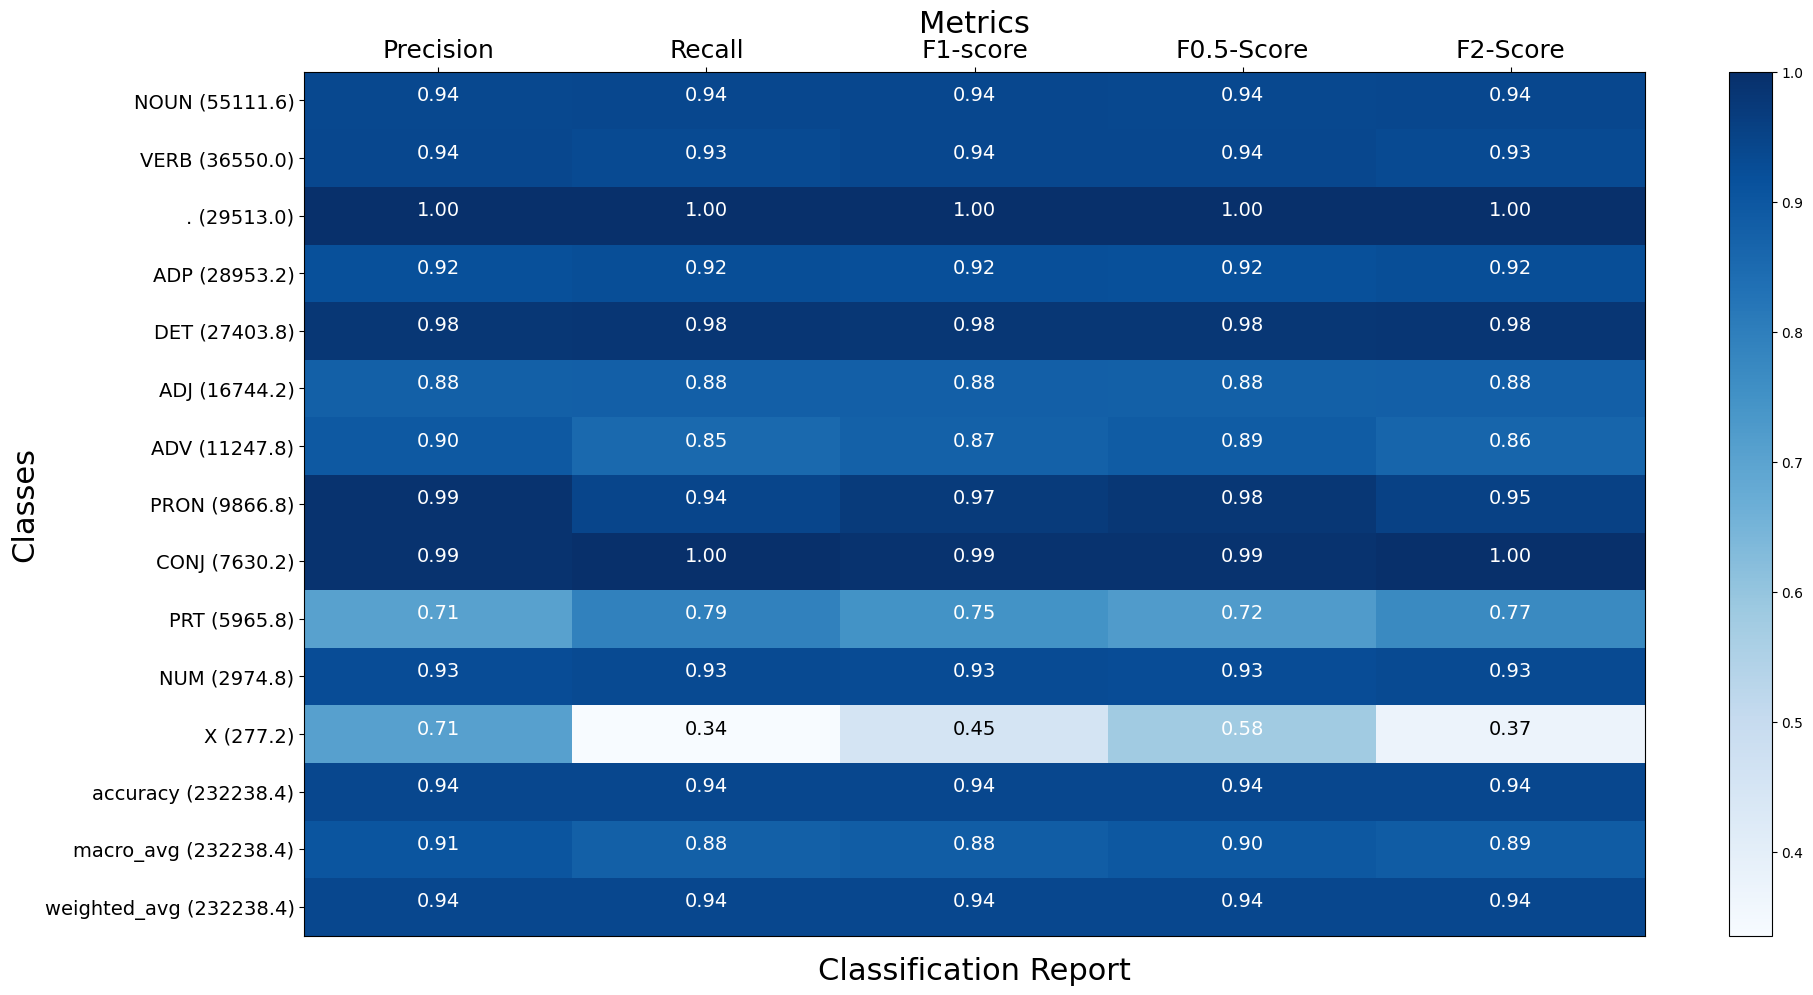

In [40]:
plotCLFReport(class_names, report, support)

<Figure size 640x480 with 0 Axes>

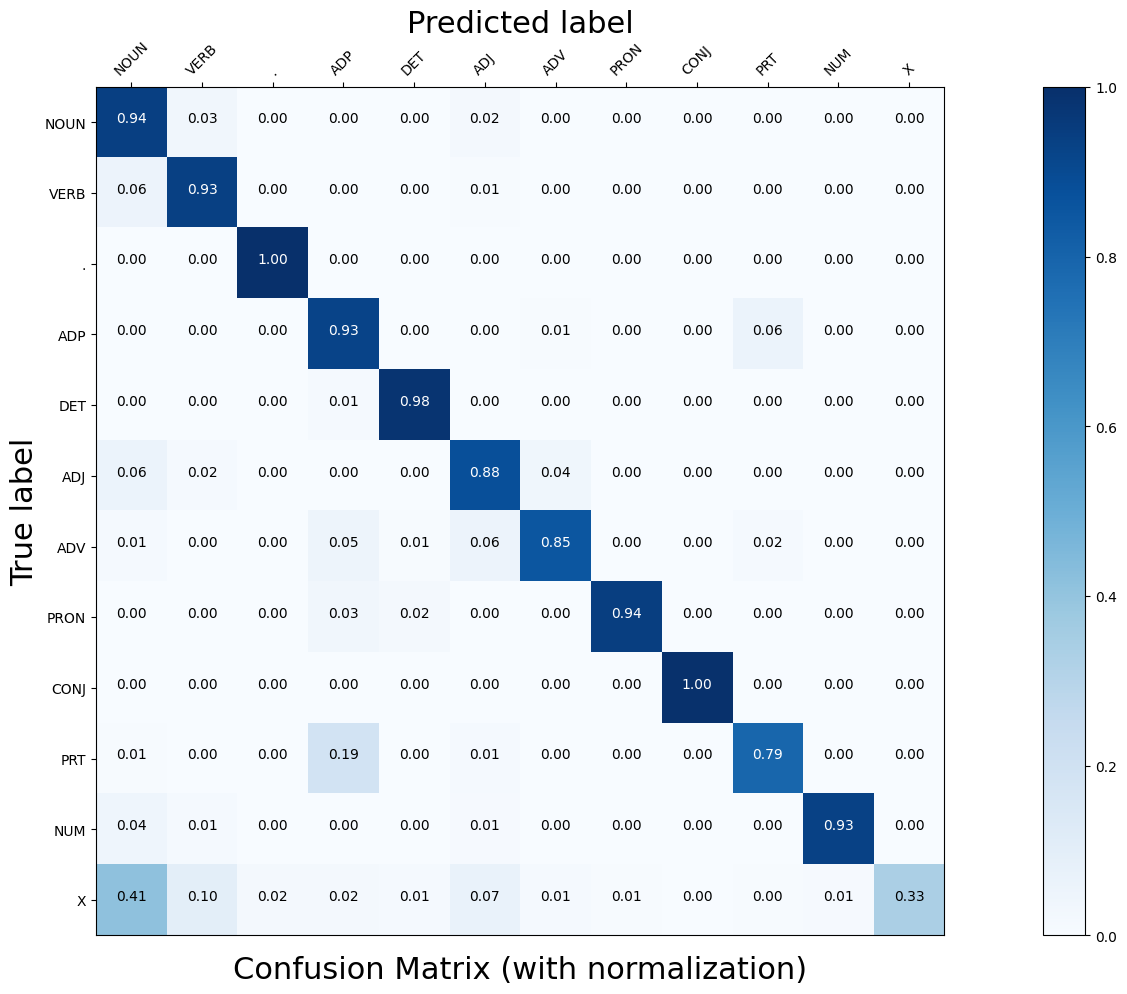

In [41]:
plotConfusionMatrix(tags, cm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

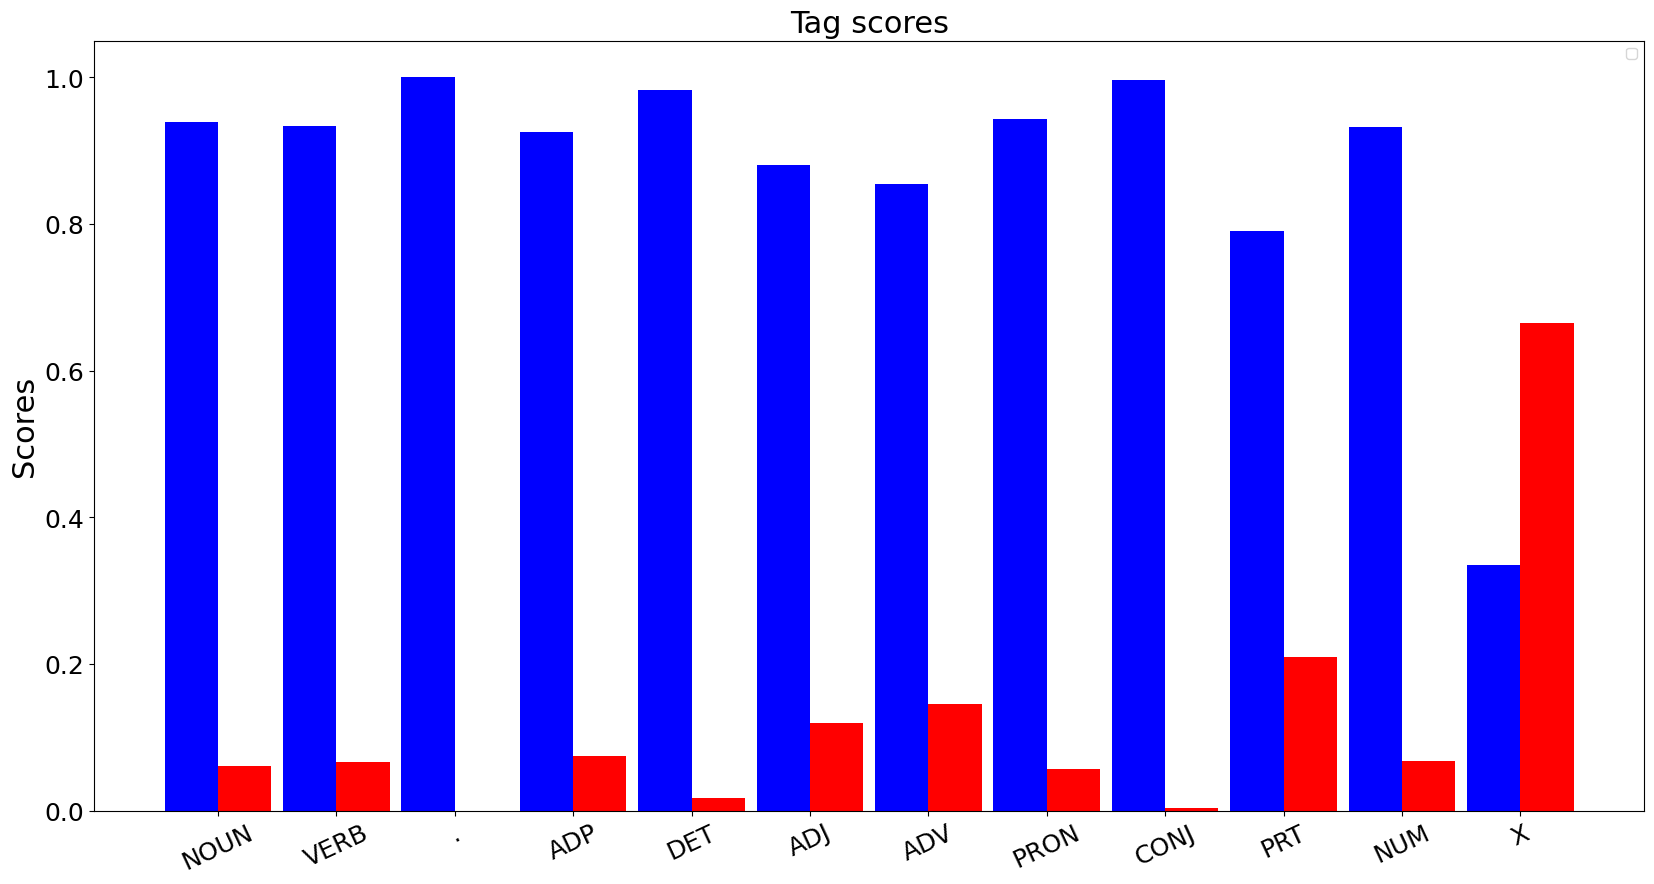

In [42]:
plotTagScores(tags, scores)

In [26]:
v_size = 128

class V():
    def __init__(self, words, test):
        self.words = words
        self.test = test
        self.tag_count = None
        self.tag_freq = None
        self.emission_probability = None
        self.transition_probability = None
        self.model_train = None
        self.model_test = None

    
    def train(self):
        tokens, tag = zip(*self.words)    
        data_w = []
        temp_w = []
        n_w = len(tokens)
        for i in range(n_w):
            temp_w.append(tokens[i])
            if tokens[i] == ".":
                data_w.append(temp_w)
                temp_w = []
        data_w.append(temp_w)
        self.model_train = gensim.models.Word2Vec(data_w, min_count = 1, vector_size = v_size, window = 5)

        data_t = []
        temp_t = []
        
        test = self.test
        n_t = len(test)
        for i in range(n_t):
            temp_t.append(test[i][0])
            if test[i][0] == ".":
                data_t.append(temp_t)
                temp_t = []
        data_t.append(temp_t)
        self.model_test = gensim.models.Word2Vec(data_t, min_count = 1, vector_size = v_size, window = 5)

        self.tag_count, self.tag_freq = tag_frequency(tag, words)
        self.emission_probability = emission_probs(tokens, words, self.tag_count)
        self.transition_probability = transition_probs(tag, words, self.tag_count)
    
    def predict(self, uSen):

        test = uSen

        # per_pos = dict.fromkeys(self.tag_freq.keys(), 0.0)
        # per_pos_count = dict.fromkeys(self.tag_freq.keys(), 0)
        pred = []

        score = 0.0
        viterbi = {}
        for tag_i in tagset:
            viterbi[tag_i] = self.transition_probability["."][tag_i]


        k = 1
        n = len(test)
        for i in range(n):

            maxi = 0.0
            max_tag = "tag"
            c = False

            for tag_i in tagset:
                em = self.emission_probability[test[i][0]][tag_i]

                if em != 0:
                    c = True

            if not c:
                lst = list(test[i])
                lst[0] = self.model_train.wv.similar_by_vector(self.model_test.wv[test[i][0]], topn=1)[0][0]
                test[i] = tuple(lst)

            viterbi_h = {}
            for tag_i in tagset:
                em = self.emission_probability[test[i][0]][tag_i]
                val = viterbi[tag_i]*em*100
                viterbi_h[tag_i] = val
                
                if val >= maxi:
                    maxi = val
                    max_tag = tag_i


            # per_pos_count[test[i][1]] = per_pos_count[test[i][1]] + 1
            pred.append(max_tag)

            # if max_tag == test[i][1]:
            #     per_pos[test[i][1]] = per_pos[test[i][1]] + 1.0
            #     score = score + 1.0


            viterbi_next = dict.fromkeys(tagset, 0)
            for tag_i in tagset:
                for tag_j in tagset:
                    viterbi_next[tag_j] = max(viterbi_next[tag_j], viterbi_h[tag_i]*self.transition_probability[tag_i][tag_j])

            if k%7 == 0:
                k = 0
                viterbi = self.tag_freq.copy()
            else:
                viterbi = viterbi_next

            k = k+1

        # for tag_i in tagset:
        #     per_pos[tag_i] = per_pos[tag_i]/per_pos_count[tag_i]
        
        return pred
    #   

    



# def Viterbi_vec(words, test): 

#     tokens, tag = zip(*words)
    
#     data_w = []
#     temp_w = []
#     n_w = len(tokens)
#     for i in range(n_w):
#         temp_w.append(tokens[i])
#         if tokens[i] == ".":
#             data_w.append(temp_w)
#             temp_w = []
#     data_w.append(temp_w)
#     model_train = gensim.models.Word2Vec(data_w, min_count = 1, vector_size = v_size, window = 5)

#     data_t = []
#     temp_t = []
    
#     n_t = len(test)
#     for i in range(n_t):
#         temp_t.append(test[i][0])
#         if test[i][0] == ".":
#             data_t.append(temp_t)
#             temp_t = []
#     data_t.append(temp_t)
#     model_test = gensim.models.Word2Vec(data_t, min_count = 1, vector_size = v_size, window = 5)

#     tag_count, tag_freq = tag_frequency(tag, words)
#     emission_probability = emission_probs(tokens, words, tag_count)
#     transition_probability = transition_probs(tag, words, tag_count)

#     per_pos = dict.fromkeys(tag_freq.keys(), 0.0)
#     per_pos_count = dict.fromkeys(tag_freq.keys(), 0)
#     pred = []

#     score = 0.0
#     viterbi = {}
#     for tag_i in tagset:
#       viterbi[tag_i] = transition_probability["."][tag_i]

#     k = 1
#     n = len(test)
#     for i in range(n):

#         maxi = 0.0
#         max_tag = "tag"
#         c = False

#         for tag_i in tagset:
#             em = emission_probability[test[i][0]][tag_i]

#             if em != 0:
#                 c = True

#         if not c:
#             lst = list(test[i])
#             lst[0] = model_train.wv.similar_by_vector(model_test.wv[test[i][0]], topn=1)[0][0]
#             test[i] = tuple(lst)

#         viterbi_h = {}
#         for tag_i in tagset:
#             em = emission_probability[test[i][0]][tag_i]
#             val = viterbi[tag_i]*em*100
#             viterbi_h[tag_i] = val
            
#             if val >= maxi:
#                 maxi = val
#                 max_tag = tag_i


#         per_pos_count[test[i][1]] = per_pos_count[test[i][1]] + 1
#         pred.append(max_tag)

#         if max_tag == test[i][1]:
#             per_pos[test[i][1]] = per_pos[test[i][1]] + 1.0
#             score = score + 1.0


#         viterbi_next = dict.fromkeys(tagset, 0)
#         for tag_i in tagset:
#             for tag_j in tagset:
#                 viterbi_next[tag_j] = max(viterbi_next[tag_j], viterbi_h[tag_i]*transition_probability[tag_i][tag_j])

#         if k%7 == 0:
#             k = 0
#             viterbi = tag_freq.copy()
        
#         else:
#             viterbi = viterbi_next

#         k = k+1

#     for tag_i in tagset:
#         per_pos[tag_i] = per_pos[tag_i]/per_pos_count[tag_i]
    
#     return pred
# #     return score*100/n, per_pos, pred


In [12]:
kFold_v1 = KFold(n_splits=5, shuffle=True, random_state=1)
tSents_v1 = np.array(words, dtype=object)
yPreds_v1 = []
yTrues_v1 = []
ls = []

In [27]:
for fold, (train, test) in enumerate(kFold_v1.split(tSents_v1)):
    trainSent = tSents_v1[train]
    testSent = tSents_v1[test]

    yPred, yTrue = [],[]
    
    ls.append(V(trainSent, testSent))
    ls[-1].train()
    ypred = ls[-1].predict(testSent)
    
    for w in (testSent):
        yTrue.append(w[1])
    
    yPreds_v.append(np.array(yPred))
    yTrues_v.append(np.array(yTrue))
    
    acc = np.sum(yTrues_v[-1] == yPreds_v[-1])/len(yTrues_v[-1])
    print(f'Fold {fold + 1} Accuracy : {acc}')

/tmp/ipykernel_5160/1713953860.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  acc = np.sum(yTrues_v[-1] == yPreds_v[-1])/len(yTrues_v[-1])


Fold 1 Accuracy : 0.0
Fold 2 Accuracy : 0.0
Fold 3 Accuracy : 0.0
Fold 4 Accuracy : 0.0
Fold 5 Accuracy : 0.0


In [ ]:
s = [('^', '^'), ('In', 'ADP'), ('his', 'DET'), ('only', 'ADJ'), ('attack', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('Republicans', 'NOUN'), (',', '.'), ('Hughes', 'NOUN'), ('said', 'VERB'), (',', '.'), ('``', '.'), ('The', 'DET'), ('three', 'NUM'), ('Republican', 'NOUN'), ('candidates', 'NOUN'), ('for', 'ADP'), ('governor', 'NOUN'), ('are', 'VERB'), ('tripping', 'VERB'), ('over', 'ADP'), ('their', 'DET'), ('feet', 'NOUN'), ('for', 'ADP'), ('popular', 'ADJ'), ('slogans', 'NOUN'), ('to', 'PRT'), ('win', 'VERB'), ('the', 'DET'), ('primary', 'NOUN'), ('.', '.'), ('$', '$')]

def func(s):
    words = []
    tags = []
    for word, tag in s:
        words += [word]
        tags += [tag]
    
    return words, tags

words, tags = func(s)
words = [x.lower() for x in words]
# print(words)
# print(words)
# print(tags)

# output = hmm_models[-1].assignTag(words)
r = 0
w = 0
for i in range(len(output)):
    if output[i] == tags[i]:
        r +=1
    else:
        w +=1
# print(output)
# print(tags)

print(f"accuracy: {r/(r+w)}")

In [24]:
total_length = len(words)
taglist = torch.empty((total_length,12),dtype=torch.float64)
for i in range(len(words)):
  taglist[i] = tagset_dict[words[i][1]].unsqueeze(0)


In [25]:
v_size = 128

def func(X, Y):
    word_tokenizer = Tokenizer()                      # instantiate tokeniser
    word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
    X_encoded = word_tokenizer.texts_to_sequences(X)
    
    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(Y)
    Y_encoded = tag_tokenizer.texts_to_sequences(Y)
    
    print(X[0])
    print(Y[0])
    print(X_encoded[0])
    print(Y_encoded[0])
    
    MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

    X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
    Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
    X, Y = X_padded, Y_padded
    
    EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
    VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

    # create an empty embedding matix
    embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

    # create a word to index dictionary mapping
    word2id = word_tokenizer.word_index

    # copy vectors from word2vec model to the words present in corpus
    for word, index in word2id.items():
        try:
            embedding_weights[index, :] = word2vec[word]
        except KeyError:
            pass
        
    Y = to_categorical(Y)
    
    return embedding_weights, Y
    

def FFNN(words, test, data_w, data_t, taglist, taglist_t):
    tokens, tag = zip(*words)
    tag_count, tag_freq = tag_frequency(tag, words)
    t_tokens,t_tag = zip(*test)
    
    a, b = func(data_w, taglist)
    
    model_train = gensim.models.Word2Vec(data_w, min_count = 1, vector_size = v_size, window = 5, workers = 4)
    n_t = len(test)

    # assign padded sequences to X and Y
    
    
    model_test = gensim.models.Word2Vec(data_t, min_count = 1, vector_size = v_size, window = 5, workers = 4)

    
    class net(nn.Module):
        def __init__(self):
            super(net,self).__init__()
            self.l1 = nn.Linear(v_size,256)
            # self.l2 = nn.Linear(256,512)
            # self.l3 = nn.Linear(256,256)
            self.l4 = nn.Linear(256,12)
            self.relu = nn.ReLU()
            self.activation = nn.ReLU()
        
        def forward(self,x):
            x = self.l1(x) 
            x = self.relu(x)
            # x = self.l2(x) 
            # x = self.relu(x)
            # x = self.l3(x) 
            # x = self.relu(x)
            x = self.l4(x) 
            x = self.relu(x)
            output = x
            return output.double()

    model = net()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 20
    model.zero_grad()
    n_train = len(tokens)//1000

    for epo in range(epochs):
        model.train()
        for i in range(1000):
            
              y_pred = model(torch.from_numpy(model_train.wv[tokens[i*n_train:(i+1)*n_train]]))

              cost = criterion(y_pred, taglist[i*n_train:(i+1)*n_train])
              optimizer.zero_grad()
              cost.backward()
              optimizer.step()
        y_pred = model(torch.from_numpy(model_train.wv[tokens]))
        cost = criterion(y_pred, taglist)
        print("cost", cost, "epoch", epo)


    y_pred = model(torch.from_numpy(model_train.wv[tokens]))
    cost = criterion(y_pred, taglist)
    rando, y_pred_tags = torch.max(y_pred, dim = 1) 
    y_pred_tags = torch.eye(12)[y_pred_tags,:]
    print(y_pred_tags.shape)
    print(taglist.shape)
    correct_pred = ((y_pred_tags == taglist)*(y_pred_tags == 1)).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    print("accuracy", acc)
    print("cost", cost)


    per_pos = torch.zeros((12,1),dtype=torch.float64)
    per_pos_count = torch.zeros((12,1),dtype=torch.int64)
    pred = []
    score = 0.0

    im_tired = []

    for tok in t_tokens:
      try:
        model_train.wv[tok]
      except:
        print("1")
        im_tired.append(model_test.wv[tok])
      else:
        print("2")
        im_tired.append(model_train.wv[tok])

    print("opop")
    i_am_tired = np.array(im_tired)
    predict = model(torch.from_numpy(i_am_tired))

    index = torch.argmax(predict,1)
    for ind in index:
      pred.append(tagset[ind])

    per_pos_count = torch.count_nonzero(taglist_t,dim=0)
    for i in range(n_t):
      per_pos[index[i]] += taglist_t[i,index[i]]
      score = score + taglist_t[i,index[i]]
      
    per_pos = per_pos/per_pos_count
    
    return pred
    return score*100/n_t, per_pos, pred


In [26]:
kFold_f = KFold(n_splits=5, shuffle=True, random_state=1)
tSents_f = np.array(words, dtype=object)
yPreds_f = []
yTrues_f = []

In [27]:
for fold, (train, test) in enumerate(kFold_f.split(tSents_f)):
    trainSent = tSents_f[train]
    testSent = tSents_f[test]
    
    tokens_w, tag_w = zip(*trainSent)
    tokens_t, tag_t = zip(*trainSent)
    data_w = []
    temp_w = []
    data_t = []
    temp_t = []
#     taglist_w = []
#     taglist_t = []

    taglist_w = torch.empty((len(trainSent),12),dtype=torch.float64)
    taglist_t = torch.empty((len(testSent),12),dtype=torch.float64)
    
    for i in range(len(trainSent)):
      taglist_w[i] = tagset_dict[trainSent[i][1]].unsqueeze(0)
    
    for i in range(len(testSent)):
      taglist_t[i] = tagset_dict[testSent[i][1]].unsqueeze(0)
    
    for j in range(len(tokens_w)):
        temp_w.append(tokens_w[j])
        if tokens_w[j] == ".":
            data_w.append(temp_w)
            temp_w = []
    data_w.append(temp_w)
    
    for j in range(len(tokens_t)):
        temp_t.append(tokens_t[j])
        if tokens_t[j] == ".":
            data_t.append(temp_t)
            temp_t = []
    data_t.append(temp_t)
    
    print("yp")
    
    X, Y = func(data_w, taglist_w)
    print(X[0])

#     yPred, yTrue = [],[]
    
#     yPred = FFNN(trainSent, testSent, data_w, data_t, taglist_w, taglist_t)
#     print("ffnn finished")
    
#     for w in (testSent):
#         yTrue.append(w[1])
    
#     yPreds_f.append(np.array(yPred))
#     yTrues_f.append(np.array(yTrue))
    
#     acc = np.sum(yTrues[-1] == yPreds[-1])/len(yTrues[-1])
#     print(f'Fold {fold + 1} Accuracy : {acc}')

yp


NameError: name 'Tokenizer' is not defined